In [3]:
import models
from models import model, create_cd_cluster, cd_diagram, bt_plot
from dataset_management import get_dataset, convert_to_autorank
from autorank import autorank, create_report, plot_stats
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

algorithm="algorithm";benchmark="bench_prior";seed="seed";budget="used_fidelity"

boundary (singular) fit: see help('isSingular') 

P-values adjusted by tukey method for family of 3 estimates
boundary (singular) fit: see help('isSingular') 

P-values adjusted by tukey method for family of 3 estimates
P-values adjusted by tukey method for family of 3 estimates
boundary (singular) fit: see help('isSingular') 

P-values adjusted by tukey method for family of 3 estimates


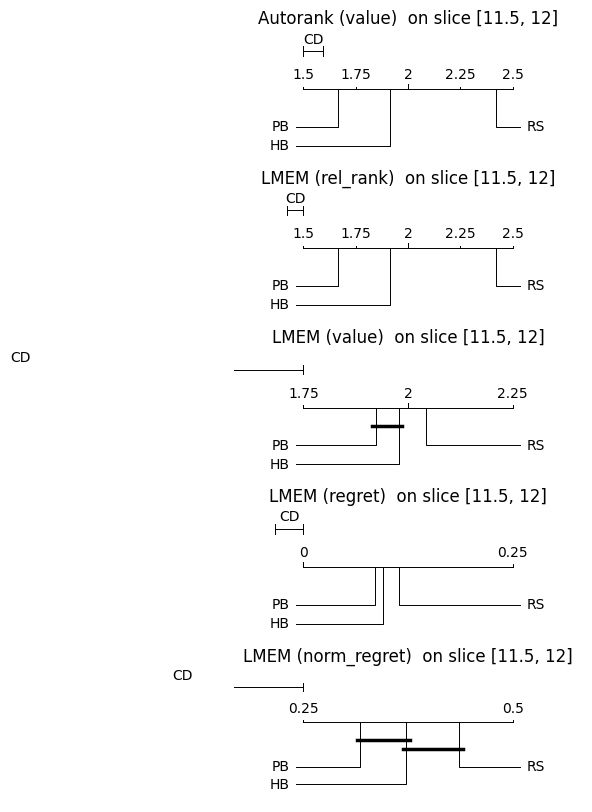

In [4]:
plot_1=bt_plot(slices=[[11.5,12]],rows=5,dataset=get_dataset(dataset_name="fig5_24_at25_bad_intsteps"),algorithm_var=algorithm,budget_var=budget)
plot_1.change_row(0,None,globality=False,loss="value")
plot_1.change_row(1,f"{algorithm}+{budget}+(1+{algorithm}|{benchmark})",globality=False,loss="rel_rank")
plot_1.change_row(2,f"{algorithm}+{budget}+(1+{algorithm}|{benchmark})",globality=False,loss="value")
plot_1.change_row(3,f"{algorithm}+{budget}+(1+{algorithm}|{benchmark})",globality=False,loss="regret")
plot_1.change_row(4,f"{algorithm}+{budget}+(1+{algorithm}|{benchmark})",globality=False,loss="norm_regret")
plot_1.show()

In [5]:
plot_2=bt_plot(slices=[[0,4],[0,8],[0,12]],rows=5,dataset=get_dataset(dataset_name="fig5_24_at25_bad_intsteps"),priors=["at25","bad"],algorithm_var=algorithm,budget_var=budget)
plot_2.change_row(0,None,globality=False,loss="value")
plot_2.change_row(1,f"{algorithm}+{budget}_group+{benchmark}",globality=True,loss="value")
plot_2.change_row(2,f"{algorithm}+{budget}_group+{benchmark}",globality=True,loss="regret")
plot_2.change_row(3,f"{algorithm}+{budget}_group+{benchmark}",globality=True,loss="norm_regret")
plot_2.change_row(4,f"{algorithm}+{budget}_group+{benchmark}",globality=True,loss="rel_rank")
plot_2.show()

TypeError: bt_plot.__init__() got an unexpected keyword argument 'priors'